In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
df = pd.read_csv('data/creditcard.csv')

In [3]:
# Transform raw time to hour of the day
# Time starts at 0 and is recorded in seconds since t0
df.loc[:, 'hour_of_day'] = df.Time.apply(lambda x: x // (60 * 60))
day_2_idx = df.hour_of_day > 23.0
df.loc[day_2_idx, 'hour_of_day'] = df.loc[day_2_idx, 'hour_of_day'].apply(lambda x: x - 24.0)

In [4]:
# Since 'Time' and 'Amount' haven't been scaled and transformed in PCA,
# these need to be similarly scaled as the other features
s_scaler = StandardScaler()
r_scaler = RobustScaler() # Robust to outliers

amounts = df.Amount.values.reshape(-1,1)
#times = df.Time.values.reshape(-1,1)
times = df.hour_of_day.values.reshape(-1,1)
df.loc[:, 'scaled_amount'] = r_scaler.fit_transform(amounts)
df.loc[:, 'scaled_time'] = s_scaler.fit_transform(times)

df.drop(['Time', 'Amount', 'hour_of_day'], axis=1, inplace=True)

In [5]:
y = df.Class
X = df.drop('Class', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [7]:
smote = SMOTE(sampling_strategy='minority')
X_over, y_over = smote.fit_resample(X_train, y_train)
df_over = pd.DataFrame(X_over, columns=X_train.columns)
df_over.loc[:, 'Class'] = y_over

In [8]:
corrs_over = np.abs(df_over.corr().Class).sort_values(ascending=False)
corrs_over = corrs_over.drop('Class')
print(corrs_over)

V14              0.762782
V4               0.707540
V11              0.702877
V12              0.686337
V10              0.642165
V16              0.612571
V17              0.573374
V9               0.572965
V3               0.563415
V2               0.505216
V18              0.481145
V7               0.479918
V1               0.423995
V6               0.407635
V5               0.393493
V19              0.302669
V20              0.199898
scaled_time      0.193058
V21              0.136716
V28              0.118087
V24              0.094208
V27              0.090505
V25              0.062652
V26              0.059335
V8               0.057387
scaled_amount    0.055708
V13              0.037012
V15              0.023131
V22              0.007363
V23              0.005877
Name: Class, dtype: float64


In [9]:
# Remove any feature with a correlation less than threshold
thresh = 0.25
(idx,) = np.where(corrs_over > thresh)
features = corrs_over[idx]
features = features.index.tolist()
features

['V14',
 'V4',
 'V11',
 'V12',
 'V10',
 'V16',
 'V17',
 'V9',
 'V3',
 'V2',
 'V18',
 'V7',
 'V1',
 'V6',
 'V5',
 'V19']

In [10]:
df_lr = df_over.loc[:, [*features, 'Class']].copy()
X_lr = df_lr.drop('Class', axis=1)
y_lr = df_lr.Class

In [11]:
clf = LogisticRegression(solver='lbfgs', max_iter=500)
clf.fit(X_lr, y_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
X_test_lr = X_test.loc[:, features].copy()

In [13]:
preds = clf.predict(X_test_lr)
preds_proba = clf.predict_proba(X_test_lr)

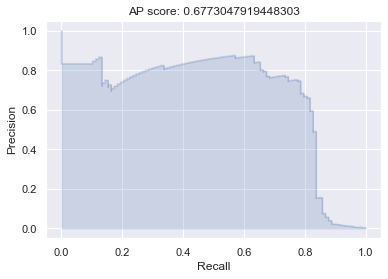

In [14]:
ap = average_precision_score(y_test, preds_proba[:,1])
precision, recall, thrs = precision_recall_curve(y_test, preds_proba[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'AP score: {ap}')
plt.show()

In [15]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [16]:
# Use RandomizedSearchCV to find optimal hyperparameters
params = {'penalty': ['l1', 'l2'],
          'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}
rand_lr = RandomizedSearchCV(LogisticRegression(solver='saga', max_iter=500), params, n_iter=10, cv=3)
rand_lr.fit(X_lr, y_lr)
preds = rand_lr.best_estimator_.predict_proba(X_test_lr)

In [17]:
rand_lr.best_params_

{'penalty': 'l2', 'C': 1000}

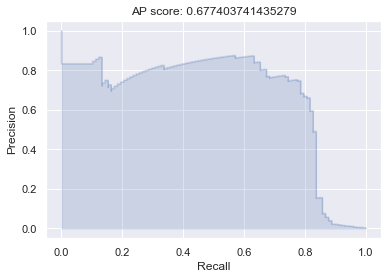

In [18]:
ap = average_precision_score(y_test, preds[:,1])
precision, recall, thrs = precision_recall_curve(y_test, preds[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'AP score: {ap}')
plt.show()

Elasticnet is fractional L1 and L2. Try a search only over elasticnet with a l1_ratio from 0 to 1. It would also be good to see the performance with penalty='none'.

In [19]:
# Use RandomizedSearchCV to find optimal hyperparameters
params = {'penalty': ['elasticnet'],
          'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
          'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1.0]}
rand_lr = RandomizedSearchCV(LogisticRegression(solver='saga', max_iter=500), params, n_iter=10, cv=3)
rand_lr.fit(X_lr, y_lr)
preds = rand_lr.best_estimator_.predict_proba(X_test_lr)

In [20]:
rand_lr.best_params_

{'penalty': 'elasticnet', 'l1_ratio': 1.0, 'C': 10}

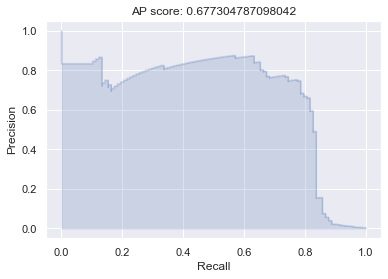

In [21]:
ap = average_precision_score(y_test, preds[:,1])
precision, recall, thrs = precision_recall_curve(y_test, preds[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'AP score: {ap}')
plt.show()

In [22]:
# See how saga performs with defaults compared to lbfgs
lr = LogisticRegression(solver='saga', max_iter=500)
lr.fit(X_lr, y_lr)
preds = lr.predict_proba(X_test_lr)
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

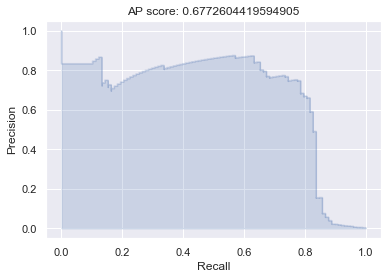

In [23]:
ap = average_precision_score(y_test, preds[:,1])
precision, recall, thrs = precision_recall_curve(y_test, preds[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'AP score: {ap}')
plt.show()

In [25]:
cm = confusion_matrix(y_test, lr.predict(X_test_lr))
cm

array([[55519,  1345],
       [   13,    85]], dtype=int64)

Overall, logistic regression is fairly reasonable. It's quick to train but there are still plenty of false positives. There's a fairly low false negative rate which might be acceptable depending on the business requirements. Customers would likely be upset with the size of false positives but the company is likely able to use this model while developing a better system.